In [2]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from catboost import Pool
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    explained_variance_score)

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasRegressor

In [3]:
# Load dataset
df = pd.read_csv("../OneDrive_1_2-2-2025/PVT_0283.csv")
print(df.columns.tolist())
X = df.drop(columns=["Pb", "Bob"])
y = df["Pb"]

['Tf', 'Rs', 'gg', 'api ', 'Pb', 'Bob']


In [4]:
# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Function to evaluate model
def evaluate_model(name, y_true, y_pred):
    mse = root_mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MSE": mse, "RMSE": rmse, "R2": r2}

results = []

In [6]:
# ------------------------
# 1. XGBoost
# ------------------------
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)
results.append(evaluate_model("XGBoost", y_test, xgb_preds))

In [7]:
# ------------------------
# 2. CatBoost
# ------------------------
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train_scaled, y_train)
cat_preds = cat_model.predict(X_test_scaled)
results.append(evaluate_model("CatBoost", y_test, cat_preds))

In [8]:
# ------------------------
# 3. Neural Network
# ------------------------
def create_nn_model():
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
    
nn_regressor = KerasRegressor(model=create_nn_model, epochs=100, batch_size=16, verbose=0)
nn_regressor.fit(X_train_scaled, y_train)
nn_preds = nn_regressor.predict(X_test_scaled)
results.append(evaluate_model("Neural Net", y_test, nn_preds))

In [9]:
# ------------------------
# 4. Stacking Ensemble
# ------------------------
stack = StackingRegressor(
    estimators=[
        ('ridge', Ridge()),
        ('rf', RandomForestRegressor(random_state=42)),
        ('xgb', XGBRegressor(random_state=42))
    ],
    final_estimator=CatBoostRegressor(verbose=0, random_state=42)
)
stack.fit(X_train_scaled, y_train)
stack_preds = stack.predict(X_test_scaled)
results.append(evaluate_model("Stacked Model", y_test, stack_preds))

In [10]:
# ------------------------
# Print Results
# ------------------------
df_results = pd.DataFrame(results)
print("\nüìä Model Performance Summary:")
print(df_results.sort_values("RMSE"))


üìä Model Performance Summary:
           Model         MSE       RMSE        R2
1       CatBoost   97.966704   9.897813  0.983487
3  Stacked Model  100.203564  10.010173  0.982724
0        XGBoost  125.518086  11.203485  0.972892
2     Neural Net  186.795294  13.667307  0.939964


# Cross-Validation Utility

In [12]:
# Split train-dev-test (for CV we'll use just train)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# ------------------------
# Cross-Validation Utility
# ------------------------
def cross_validate_model(name, model, X, y):
    print(f"\nüìä Cross-Validation for {name} (5-Fold):")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    rmse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2', n_jobs=-1)

    for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
        print(f"  Fold {i}: RMSE = {rmse:.2f}, R¬≤ = {r2:.4f}")

    print(f"\n‚úÖ Summary for {name}:")
    print(f"  RMSE: Mean = {rmse_scores.mean():.2f}, Std = {rmse_scores.std():.2f}")
    print(f"  R¬≤:   Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")

In [14]:
# ------------------------
# Model 1: CatBoost Pipeline
# ------------------------
cat_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('catboost', CatBoostRegressor(verbose=0, random_state=42))
])
cross_validate_model("CatBoost", cat_pipe, X_train, y_train)


üìä Cross-Validation for CatBoost (5-Fold):
  Fold 1: RMSE = 131.00, R¬≤ = 0.9797
  Fold 2: RMSE = 78.72, R¬≤ = 0.9911
  Fold 3: RMSE = 67.78, R¬≤ = 0.9943
  Fold 4: RMSE = 119.59, R¬≤ = 0.9824
  Fold 5: RMSE = 137.76, R¬≤ = 0.9712

‚úÖ Summary for CatBoost:
  RMSE: Mean = 106.97, Std = 28.35
  R¬≤:   Mean = 0.9837, Std = 0.0083


In [15]:
# ------------------------
# Model 2: XGBoost Pipeline
# ------------------------
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42))
])
cross_validate_model("XGBoost", xgb_pipe, X_train, y_train)


üìä Cross-Validation for XGBoost (5-Fold):
  Fold 1: RMSE = 151.39, R¬≤ = 0.9729
  Fold 2: RMSE = 95.96, R¬≤ = 0.9867
  Fold 3: RMSE = 112.38, R¬≤ = 0.9844
  Fold 4: RMSE = 170.34, R¬≤ = 0.9643
  Fold 5: RMSE = 124.08, R¬≤ = 0.9767

‚úÖ Summary for XGBoost:
  RMSE: Mean = 130.83, Std = 26.78
  R¬≤:   Mean = 0.9770, Std = 0.0081


In [16]:
# Model 3: Neural Network Pipeline
# ------------------------
def create_nn_model():
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

nn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_nn_model, epochs=100, batch_size=16, verbose=0))
])
cross_validate_model("Neural Network", nn_pipe, X_train, y_train)


üìä Cross-Validation for Neural Network (5-Fold):
  Fold 1: RMSE = 212.40, R¬≤ = 0.9517
  Fold 2: RMSE = 214.89, R¬≤ = 0.9324
  Fold 3: RMSE = 229.28, R¬≤ = 0.9365
  Fold 4: RMSE = 286.28, R¬≤ = 0.9055
  Fold 5: RMSE = 284.27, R¬≤ = 0.8829

‚úÖ Summary for Neural Network:
  RMSE: Mean = 245.42, Std = 33.05
  R¬≤:   Mean = 0.9218, Std = 0.0245


# ü•â Hyperparameter Tuning + CV

In [18]:
# ------------------------
# 1. Load and Split Dataset
# ------------------------
df = pd.read_csv("PVT_0283.csv")  # Update path if needed
X = df.drop(columns=["Pb", "Bob"])
y = df["Pb"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ------------------------
# 2. Scale Features
# ------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_dev_scaled = scaler.transform(X_dev)

In [19]:
# ------------------------
# 3. CatBoost Hyperparameter Tuning
# ------------------------
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [300, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_model = CatBoostRegressor(verbose=0, random_state=42)

search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train)
best_cat = search.best_estimator_
best_params = search.best_params_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


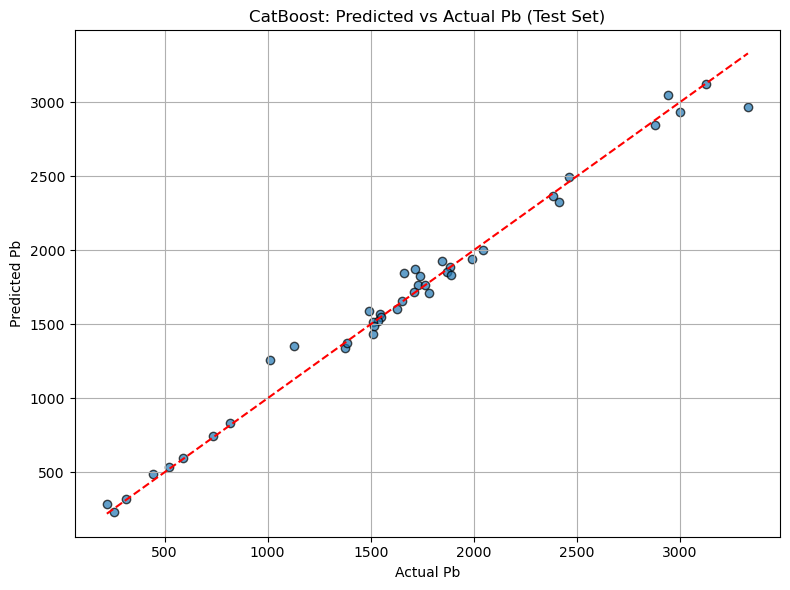


‚úÖ Test Set RMSE: 95.16
üîß Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 4}


In [20]:
# ------------------------
# 4. Evaluation on Test Set
# ------------------------
y_test_pred = best_cat.predict(X_test_scaled)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Pb')
plt.ylabel('Predicted Pb')
plt.title('CatBoost: Predicted vs Actual Pb (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n‚úÖ Test Set RMSE: {test_rmse:.2f}")
print("üîß Best Parameters:", best_params)

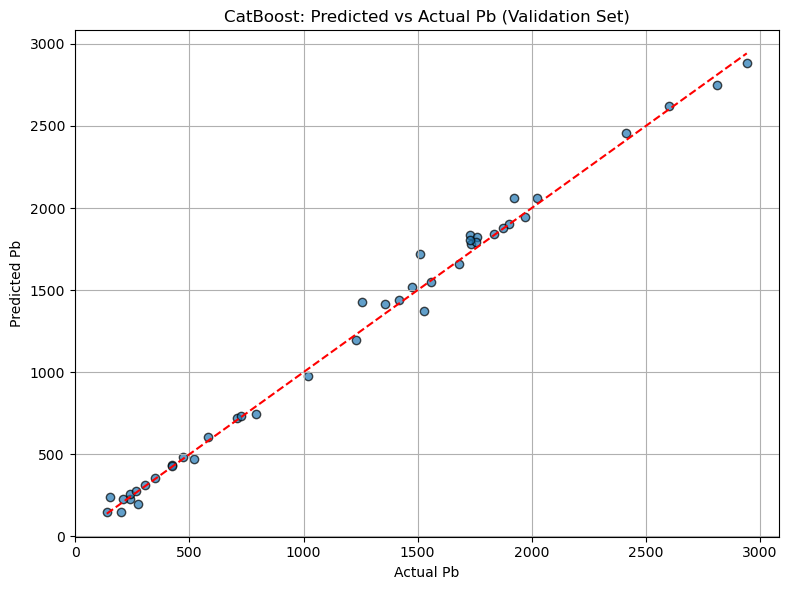


üìã Validation Set RMSE: 65.86


In [21]:
# ------------------------
# 5. Evaluation on Validation Set
# ------------------------
y_dev_pred = best_cat.predict(X_dev_scaled)
dev_rmse = root_mean_squared_error(y_dev, y_dev_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_dev, y_dev_pred, alpha=0.7, edgecolor='k')
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')
plt.xlabel('Actual Pb')
plt.ylabel('Predicted Pb')
plt.title('CatBoost: Predicted vs Actual Pb (Validation Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nüìã Validation Set RMSE: {dev_rmse:.2f}")

# CatBoost Feature Importances


üìä CatBoost Feature Importances:
  Feature  Importance
1      Rs   69.283996
2      gg   20.346657
0      Tf    7.905398
3    api     2.463949


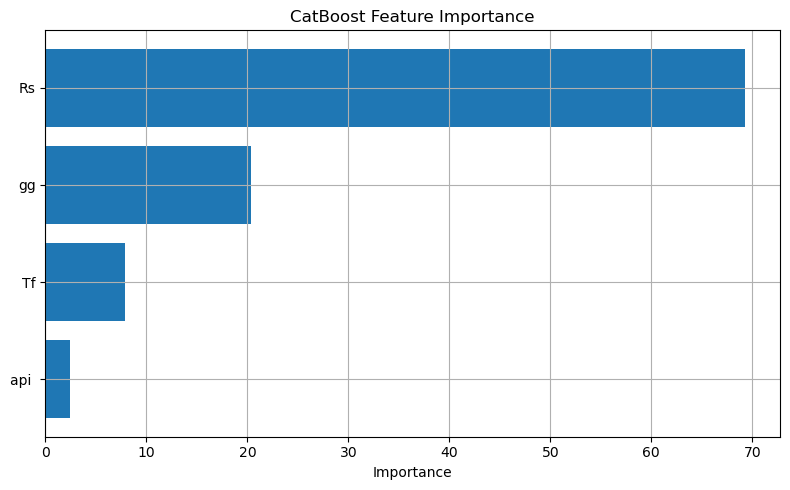

In [23]:
# Re-train best CatBoost model on full training set
cat_model = CatBoostRegressor(
    learning_rate=0.05,
    depth=4,
    iterations=500,
    l2_leaf_reg=7,
    verbose=0,
    random_state=42
)
cat_model.fit(X_train_scaled, y_train)

# Get feature importance (built-in)
feature_names = list(X.columns)
importances = cat_model.get_feature_importance(Pool(X_train_scaled, label=y_train, feature_names=feature_names))

# Create DataFrame for readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print("\nüìä CatBoost Feature Importances:")
print(feature_importance_df)

# Optional: Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optimized CatBoost Model


In [25]:
# ------------------------
# Optimized CatBoost Model
# ------------------------
cat_model = CatBoostRegressor(
    learning_rate=0.03,
    depth=6,
    iterations=1000,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)
cat_model.fit(X_train_scaled, y_train)


üìä CatBoost-Only RMSE (Test Set): 97.10
üìã CatBoost-Only RMSE (Validation Set): 55.54


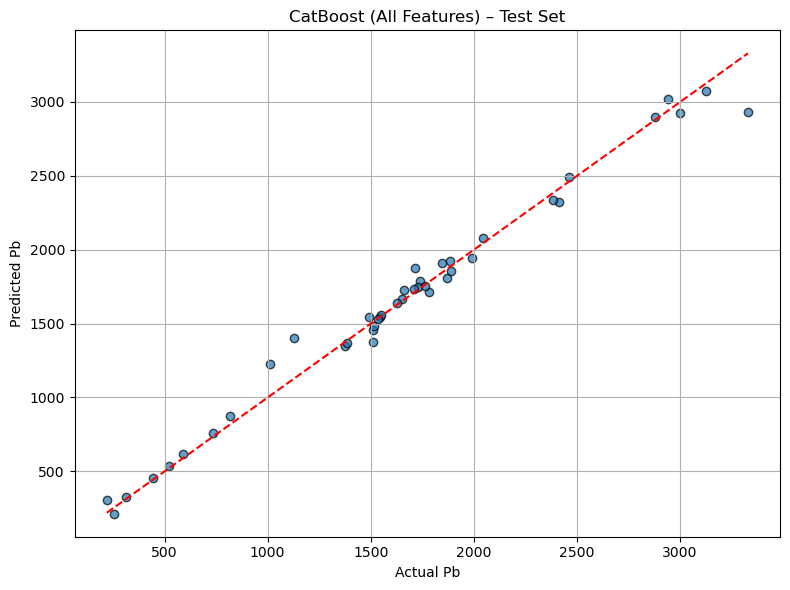

In [26]:

# ------------------------
# Evaluation
# ------------------------
# Predict on test and dev
y_test_pred = cat_model.predict(X_test_scaled)
y_dev_pred = cat_model.predict(X_dev_scaled)

# RMSE
test_rmse = root_mean_squared_error(y_test, y_test_pred)
dev_rmse = root_mean_squared_error(y_dev, y_dev_pred)

print(f"\nüìä CatBoost-Only RMSE (Test Set): {test_rmse:.2f}")
print(f"üìã CatBoost-Only RMSE (Validation Set): {dev_rmse:.2f}")


# ------------------------
# Plot Predicted vs Actual
# ------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Pb")
plt.ylabel("Predicted Pb")
plt.title("CatBoost (All Features) ‚Äì Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()

# Sample Weights & Reverse Log
Applies a log-transformed CatBoost regression model to predict bubble point pressure (Pb), with sample weights added to emphasize higher Pb values. After data cleaning and feature scaling, the model is trained on the log-transformed target to stabilize variance and improve learning.


üìä Weighted Log-CatBoost RMSE (Test): 104.91
üìã Weighted Log-CatBoost RMSE (Validation): 58.58


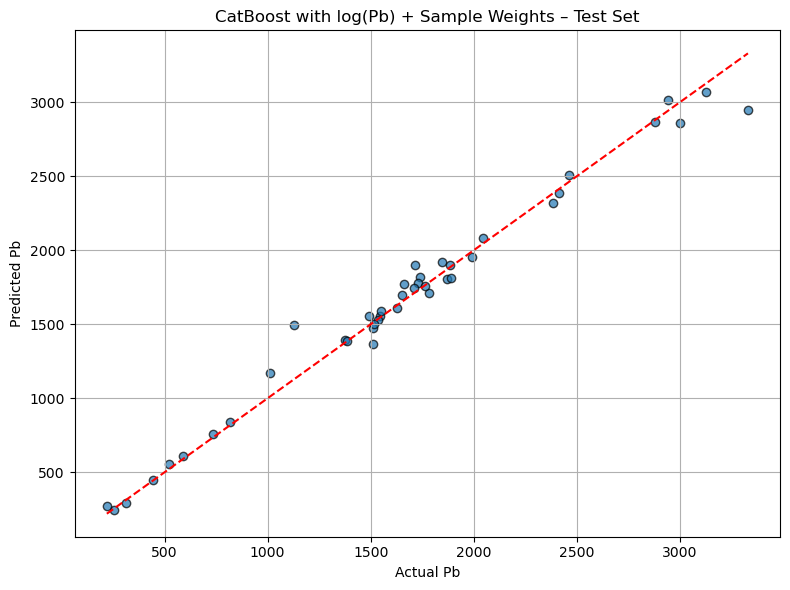

In [28]:
# ------------------------
# 1. Load & Clean Dataset
# ------------------------
df = pd.read_csv("PVT_0283.csv")
df.columns = df.columns.str.strip()

X = df.drop(columns=["Pb", "Bob"])
y_original = df["Pb"]
y = np.log1p(y_original)  # ‚úÖ Log-transform Pb

# ------------------------
# 2. Train/Dev/Test Split
# ------------------------
X_train, X_temp, y_train, y_temp, y_train_orig, y_temp_orig = train_test_split(
    X, y, y_original, test_size=0.3, random_state=42
)
X_test, X_dev, y_test, y_dev, y_test_orig, y_dev_orig = train_test_split(
    X_temp, y_temp, y_temp_orig, test_size=0.5, random_state=42
)

# ------------------------
# 3. Scale Features
# ------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_dev_scaled = scaler.transform(X_dev)

# ------------------------
# 4. Sample Weights (focus on high Pb values)
# ------------------------
weights = y_train_orig / y_train_orig.max()  # More weight to larger Pb

# ------------------------
# 5. Train CatBoost
# ------------------------
cat_model = CatBoostRegressor(
    learning_rate=0.03,
    depth=6,
    iterations=1000,
    l2_leaf_reg=3,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)
cat_model.fit(X_train_scaled, y_train, sample_weight=weights)

# ------------------------
# 6. Predict and Reverse Log
# ------------------------
y_test_pred_log = cat_model.predict(X_test_scaled)
y_dev_pred_log = cat_model.predict(X_dev_scaled)

# Back to original scale
y_test_pred = np.expm1(y_test_pred_log)
y_dev_pred = np.expm1(y_dev_pred_log)

# ------------------------
# 7. Evaluate
# ------------------------
test_rmse = root_mean_squared_error(y_test_orig, y_test_pred)
dev_rmse = root_mean_squared_error(y_dev_orig, y_dev_pred)

print(f"\nüìä Weighted Log-CatBoost RMSE (Test): {test_rmse:.2f}")
print(f"üìã Weighted Log-CatBoost RMSE (Validation): {dev_rmse:.2f}")

# ------------------------
# 8. Plot
# ------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Pb")
plt.ylabel("Predicted Pb")
plt.title("CatBoost with log(Pb) + Sample Weights ‚Äì Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()


# ü•à Smart Prediction Logic
Implement a Mixture of Experts approach to improve the prediction of bubble point pressure (Pb). It begins by loading and preprocessing a dataset, then splits it into training, testing, and development sets. A general CatBoost model is trained on the full dataset, while a specialist model is trained specifically on high Pb values (Pb > 2500). During prediction, the system uses the specialist model for high Pb cases and the general model for others. The combined predictions are then evaluated using RMSE to assess performance improvements.


üìä Mixture of Experts RMSE (Test): 88.58
üîç General Model RMSE: 97.10
üîç Specialist Model RMSE (on high Pb only): 143.59


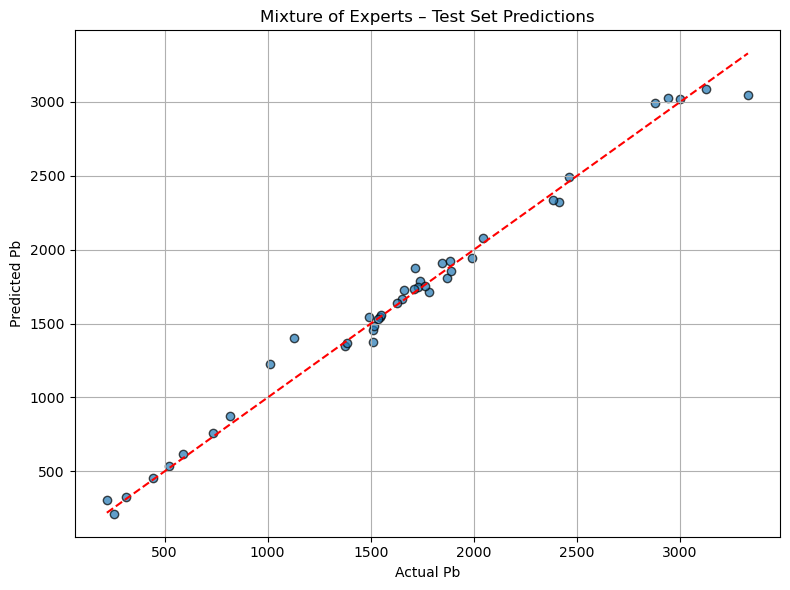

In [30]:
# ------------------------
# 1. Load and Prepare Dataset
# ------------------------
df = pd.read_csv("PVT_0283.csv")
df.columns = df.columns.str.strip()

# Define target and features
X = df.drop(columns=["Pb", "Bob"])
y = df["Pb"]

# Add Pb_bin: 1 = high Pb (hard cases), 0 = low Pb (easy)
df["Pb_bin"] = (df["Pb"] > 2500).astype(int)

# ------------------------
# 2. Train/Test/Dev Split
# ------------------------
X_train, X_temp, y_train, y_temp, bin_train, bin_temp = train_test_split(
    X, y, df["Pb_bin"], test_size=0.3, random_state=42
)
X_test, X_dev, y_test, y_dev, bin_test, bin_dev = train_test_split(
    X_temp, y_temp, bin_temp, test_size=0.5, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_dev_scaled = scaler.transform(X_dev)

# ------------------------
# 3. General CatBoost Model (all data)
# ------------------------
main_model = CatBoostRegressor(
    learning_rate=0.03, depth=6, iterations=1000, l2_leaf_reg=3,
    verbose=0, random_state=42
)
main_model.fit(X_train_scaled, y_train)

# ------------------------
# 4. Specialist Model (only high Pb)
# ------------------------
X_train_high = X_train_scaled[bin_train == 1]
y_train_high = y_train[bin_train == 1]

X_test_high = X_test_scaled[bin_test == 1]
y_test_high = y_test[bin_test == 1]

specialist_model = CatBoostRegressor(
    learning_rate=0.05, depth=4, iterations=700, l2_leaf_reg=5,
    verbose=0, random_state=42
)
specialist_model.fit(X_train_high, y_train_high)

# ------------------------
# 5. Smart Prediction Logic
# ------------------------
main_preds = main_model.predict(X_test_scaled)
special_preds = specialist_model.predict(X_test_scaled)

# Where Pb_bin == 1 (likely high Pb), use specialist prediction
combined_preds = np.where(bin_test == 1, special_preds, main_preds)

# ------------------------
# 6. Evaluate
# ------------------------
rmse_combined = root_mean_squared_error(y_test, combined_preds)
print(f"\nüìä Mixture of Experts RMSE (Test): {rmse_combined:.2f}")

# Optional: Compare both models
rmse_main = root_mean_squared_error(y_test, main_preds)
rmse_specialist = root_mean_squared_error(y_test_high, specialist_model.predict(X_test_high))

print(f"üîç General Model RMSE: {rmse_main:.2f}")
print(f"üîç Specialist Model RMSE (on high Pb only): {rmse_specialist:.2f}")

import matplotlib.pyplot as plt

# ------------------------
# 7. Scatter Plot ‚Äì Actual vs Predicted
# ------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, combined_preds, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Pb")
plt.ylabel("Predicted Pb")
plt.title("Mixture of Experts ‚Äì Test Set Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

# ü•á Log-Transformed CatBoost Regression with Feature Engineering and Outlier-Aware Evaluation + Outliers
We implemented a CatBoost regression model to predict bubble point pressure (Pb) using a feature-engineered and log-transformed dataset. The features were scaled, and sample weights were applied to emphasize higher Pb values. The model was trained on the log-transformed target, with predictions inverse-transformed for accurate evaluation. To enhance robustness, additional analysis was conducted by filtering outliers from the test set and recalculating performance metrics.

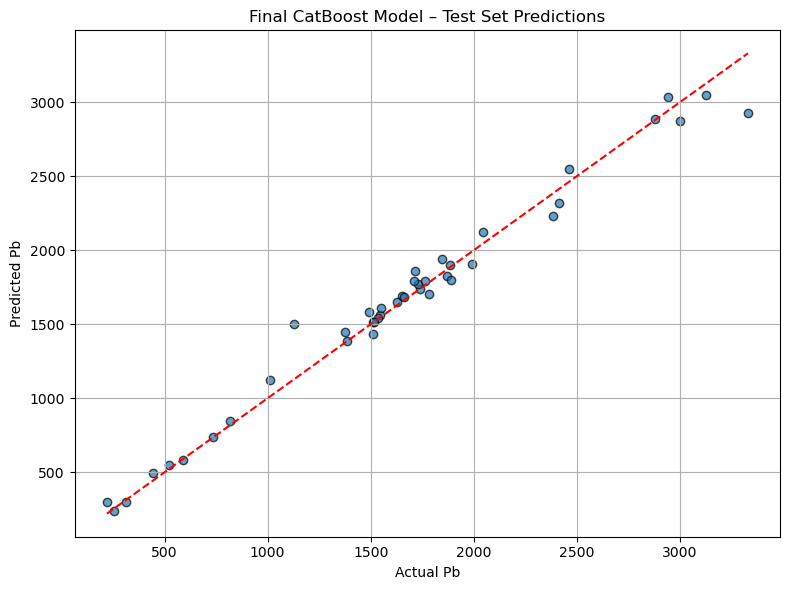


üìä Final Model Performance ‚Äì Test Set:
‚úÖ RMSE:              107.96
‚úÖ MAE:               70.25
‚úÖ MAPE:              5.23%
‚úÖ Median AE:         53.81
‚úÖ R¬≤:                0.9799
‚úÖ Explained Variance:0.9801

üìã Final Model Performance ‚Äì Validation Set:
‚úÖ RMSE:              58.31
‚úÖ MAE:               39.53
‚úÖ MAPE:              4.63%
‚úÖ Median AE:         26.23
‚úÖ R¬≤:                0.9946
‚úÖ Explained Variance: 0.9951

üìâ Performance Without Outliers ‚Äì Test Set:
‚úÖ RMSE:      96.17
‚úÖ MAE:       66.37
‚úÖ R¬≤:        0.9401


In [32]:
# ------------------------
# 1. Load & Clean Dataset
# ------------------------
df = pd.read_csv("PVT_0283.csv")
df.columns = df.columns.str.strip()

# ------------------------
# 2. Feature Engineering
# ------------------------
df["Rs_api"] = df["Rs"] / df["api"]
df["gg_squared"] = df["gg"] ** 2
df["Tf_api"] = df["Tf"] * df["api"]
df["log_Rs"] = np.log1p(df["Rs"])

# ------------------------
# 3. Define Features and Target
# ------------------------
X = df.drop(columns=["Pb", "Bob"])
y_original = df["Pb"]
y_log = np.log1p(y_original)  # ‚úÖ Log transform target

# ------------------------
# 4. Split Dataset
# ------------------------
X_train, X_temp, y_train_log, y_temp_log, y_train_orig, y_temp_orig = train_test_split(
    X, y_log, y_original, test_size=0.3, random_state=42
)
X_test, X_dev, y_test_log, y_dev_log, y_test_orig, y_dev_orig = train_test_split(
    X_temp, y_temp_log, y_temp_orig, test_size=0.5, random_state=42
)

# ------------------------
# 5. Feature Scaling
# ------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_dev_scaled = scaler.transform(X_dev)

# ------------------------
# 6. Sample Weights (prioritize large Pb)
# ------------------------
weights = y_train_orig / y_train_orig.max()

# ------------------------
# 7. Train CatBoost Model
# ------------------------
cat_model = CatBoostRegressor(
    learning_rate=0.03,
    depth=6,
    iterations=1000,
    l2_leaf_reg=3,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)
cat_model.fit(X_train_scaled, y_train_log, sample_weight=weights)

# ------------------------
# 8. Predict and Invert Log
# ------------------------
y_test_pred_log = cat_model.predict(X_test_scaled)
y_dev_pred_log = cat_model.predict(X_dev_scaled)

y_test_pred = np.expm1(y_test_pred_log)
y_dev_pred = np.expm1(y_dev_pred_log)

# ------------------------
# 9. Evaluate
# ------------------------
# Test Set Metrics
rmse_test = root_mean_squared_error(y_test_orig, y_test_pred)
mae_test = mean_absolute_error(y_test_orig, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
medae_test = median_absolute_error(y_test_orig, y_test_pred)
r2_test = r2_score(y_test_orig, y_test_pred)
ev_test = explained_variance_score(y_test_orig, y_test_pred)

# Validation Set Metrics
rmse_dev = root_mean_squared_error(y_dev_orig, y_dev_pred)
mae_dev = mean_absolute_error(y_dev_orig, y_dev_pred)
mape_dev = mean_absolute_percentage_error(y_dev_orig, y_dev_pred)
medae_dev = median_absolute_error(y_dev_orig, y_dev_pred)
r2_dev = r2_score(y_dev_orig, y_dev_pred)
ev_dev = explained_variance_score(y_dev_orig, y_dev_pred)

# ------------------------
# 10. Plot
# ------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Pb")
plt.ylabel("Predicted Pb")
plt.title("Final CatBoost Model ‚Äì Test Set Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------
# 11. Print All Metrics
# ------------------------
print("\nüìä Final Model Performance ‚Äì Test Set:")
print(f"‚úÖ RMSE:              {rmse_test:.2f}")
print(f"‚úÖ MAE:               {mae_test:.2f}")
print(f"‚úÖ MAPE:              {mape_test:.2%}")
print(f"‚úÖ Median AE:         {medae_test:.2f}")
print(f"‚úÖ R¬≤:                {r2_test:.4f}")
print(f"‚úÖ Explained Variance:{ev_test:.4f}")

print("\nüìã Final Model Performance ‚Äì Validation Set:")
print(f"‚úÖ RMSE:              {rmse_dev:.2f}")
print(f"‚úÖ MAE:               {mae_dev:.2f}")
print(f"‚úÖ MAPE:              {mape_dev:.2%}")
print(f"‚úÖ Median AE:         {medae_dev:.2f}")
print(f"‚úÖ R¬≤:                {r2_dev:.4f}")
print(f"‚úÖ Explained Variance: {ev_dev:.4f}")

# ------------------------
# 12. Recalculate Without Outliers
# ------------------------
Q1 = y_test_orig.quantile(0.25)
Q3 = y_test_orig.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (y_test_orig >= lower_bound) & (y_test_orig <= upper_bound)
y_test_filtered = y_test_orig[mask]
y_pred_filtered = y_test_pred[mask]

rmse_no_outliers = root_mean_squared_error(y_test_filtered, y_pred_filtered)
mae_no_outliers = mean_absolute_error(y_test_filtered, y_pred_filtered)
r2_no_outliers = r2_score(y_test_filtered, y_pred_filtered)

print("\nüìâ Performance Without Outliers ‚Äì Test Set:")
print(f"‚úÖ RMSE:      {rmse_no_outliers:.2f}")
print(f"‚úÖ MAE:       {mae_no_outliers:.2f}")
print(f"‚úÖ R¬≤:        {r2_no_outliers:.4f}")